<a href="https://colab.research.google.com/github/yashaswi1307/M11_PA2/blob/main/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What drives the price of a car?

![](C:/content/images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### CRISP-DM Framework

<center>
    <img src = C:/content/images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import randint, uniform

In [32]:
# Load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/content/data/vehicles.csv')

**Business Objective:**
A used-car dealership seeks to identify which vehicle attributes most significantly impact resale price for pricing decisions.

**Data Mining Objective:**
Formulate a supervised regression task to predict a car's sale price from features including year, manufacturer, odometer reading, condition, and geographic region.

**Success Criteria:**
    - Achieve a cross-validated R² ≥ 0.65 on the hold-out set.
    - Extract the top five features by importance (e.g., age, mileage, brand) for actionable insights.
    - Quantify marginal effects: e.g., dollar impact per additional year of age or per 10,000 miles.

In [33]:
# Visualize data
print(f"Dataset shape: {df.shape}")
print("Available columns:", df.columns.tolist())

Dataset shape: (426880, 18)
Available columns: ['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'state']


In [34]:
# Investigate the data
df.info()
#Total rows: 426880
#Total columns: 17

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [35]:
# Print statistics summary
numeric_cols = ['price', 'year', 'odometer']
print(df[numeric_cols].describe())

              price           year      odometer
count  4.268800e+05  425675.000000  4.224800e+05
mean   7.519903e+04    2011.235191  9.804333e+04
std    1.218228e+07       9.452120  2.138815e+05
min    0.000000e+00    1900.000000  0.000000e+00
25%    5.900000e+03    2008.000000  3.770400e+04
50%    1.395000e+04    2013.000000  8.554800e+04
75%    2.648575e+04    2017.000000  1.335425e+05
max    3.736929e+09    2022.000000  1.000000e+07


In [36]:
# Print missin rates and duplicates
missing_rates = df.isnull().mean().sort_values(ascending=False)
print("Missing rates per column:\n", missing_rates)
print(f"Duplicate IDs: {df.duplicated(subset=['id']).sum()}")


Missing rates per column:
 size            0.717675
cylinders       0.416225
condition       0.407852
VIN             0.377254
drive           0.305863
paint_color     0.305011
type            0.217527
manufacturer    0.041337
title_status    0.019308
model           0.012362
odometer        0.010307
fuel            0.007058
transmission    0.005988
year            0.002823
region          0.000000
id              0.000000
price           0.000000
state           0.000000
dtype: float64
Duplicate IDs: 0


In [37]:
# Count categories
for col in ['manufacturer', 'condition', 'region', 'title_status']:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts(dropna=False).head(10))


Value counts for manufacturer:
manufacturer
ford         70985
chevrolet    55064
toyota       34202
honda        21269
nissan       19067
jeep         19014
ram          18342
NaN          17646
gmc          16785
bmw          14699
Name: count, dtype: int64

Value counts for condition:
condition
NaN          174104
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: count, dtype: int64

Value counts for region:
region
columbus                    3608
jacksonville                3562
spokane / coeur d'alene     2988
eugene                      2985
fresno / madera             2983
orlando                     2983
bend                        2982
omaha / council bluffs      2982
new hampshire               2981
kennewick-pasco-richland    2981
Name: count, dtype: int64

Value counts for title_status:
title_status
clean         405117
NaN             8242
rebuilt         7219
salvage         3868
lien            

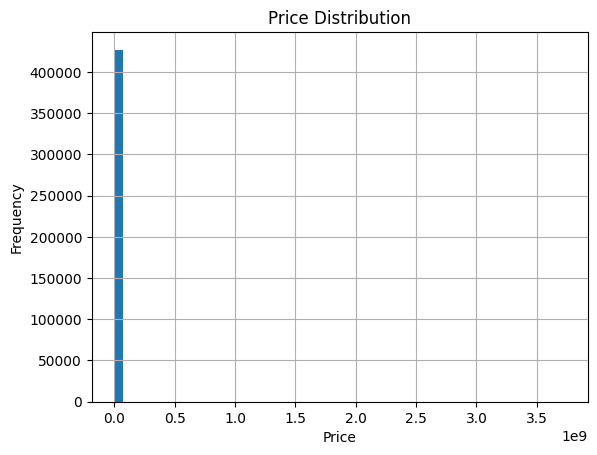

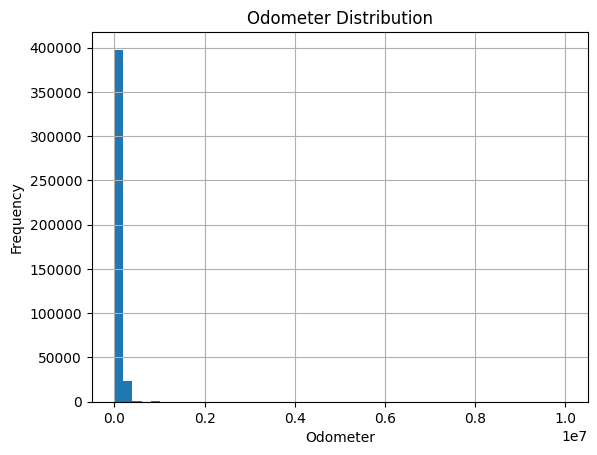

In [38]:
# Create a Distribution Plots
plt.figure()
df['price'].hist(bins=50)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

plt.figure()
df['odometer'].hist(bins=50)
plt.title('Odometer Distribution')
plt.xlabel('Odometer')
plt.ylabel('Frequency')
plt.show()

In [39]:
# Crate Outlier Detection
# Identify vehicles with price or odometer in the top 1%
price_threshold = df['price'].quantile(0.99)
odometer_threshold = df['odometer'].quantile(0.99)
print(f"Top 1% price threshold: {price_threshold}")
print(f"Top 1% odometer threshold: {odometer_threshold}")

high_price = df[df['price'] > price_threshold]
high_mileage = df[df['odometer'] > odometer_threshold]
print(f"Records > 99th percentile price: {len(high_price)}")
print(f"Records > 99th percentile odometer: {len(high_mileage)}")

Top 1% price threshold: 66995.0
Top 1% odometer threshold: 280000.0
Records > 99th percentile price: 4265
Records > 99th percentile odometer: 4166


In [40]:
# Verify all missing values
print(df.isnull().sum())

id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [41]:
# Remove missing values from critical fields
df = df.dropna(subset=['price', 'year'])

In [42]:
# Optional outlier removal
price_cap = df['price'].quantile(0.99)
odometer_cap = df['odometer'].quantile(0.99)
df = df[df['price'] <= price_cap]
df = df[df['odometer'] <= odometer_cap]

In [43]:
# Feature engineering
CURRENT_YEAR = 2025
df['age'] = CURRENT_YEAR - df['year']
df['log_odometer'] = np.log1p(df['odometer'])
# Age buckets
df['age_bucket'] = pd.cut(
    df['age'], bins=[0,5,10,15,20,100],
    labels=['0-5','6-10','11-15','16-20','20+'], right=False
)

In [44]:
# Assemble feature matrix and target
def assemble_features(df):
    # Select features
    target = df['price']
    features = ['age','log_odometer','manufacturer','region','condition','age_bucket']
    X = df[features].copy()
    return X, df['price']

X, y = assemble_features(df)

In [45]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [46]:
# Preprocessing & pipeline for sklearn
numeric_features = ['age','log_odometer']
categorical_features = ['manufacturer','region','condition','age_bucket']

# Numeric pipeline: impute missing then scale
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# Categorical pipeline: impute missing then one-hot encode
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
])

In [47]:
# Full modeling pipeline
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

In [48]:
# Fit pipeline and inspect
model_pipeline.fit(X_train, y_train)

# Get transformed feature matrix shape
X_tr = model_pipeline.named_steps['preprocessor'].transform(X_train)
print(f"Pipeline fitted. Transformed training shape: {X_tr.shape}")

Pipeline fitted. Transformed training shape: (330432, 462)


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [49]:
# Define pipelines for different regressors
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])

ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])
ridge_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=3, scoring='r2', n_jobs=-1)
print(f"Ridge CV R²: {ridge_scores.mean():.3f} ± {ridge_scores.std():.3f}")

In [50]:
# Ridge Regression with cross-validation
ridge_scores = cross_val_score(ridge_pipeline, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)
print(f"Ridge CV R²: {ridge_scores.mean():.3f} ± {ridge_scores.std():.3f}")

Ridge CV R²: 0.367 ± 0.003


In [60]:
# Random Forest Randomized Search (faster)
import time
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf_param_dist = {
    'regressor__n_estimators': randint(30, 80),
    'regressor__max_depth': randint(5, 15)
}
random_rf = RandomizedSearchCV(
    rf_pipeline, rf_param_dist, n_iter=2, cv=2, scoring='r2', n_jobs=-1, random_state=42
)
start_rf = time.time()
random_rf.fit(X_train, y_train)
end_rf = time.time()
print(f"Best RF params: {random_rf.best_params_}")
print(f"RF CV R²: {random_rf.best_score_:.3f}")
print(f"Random Forest search time: {(end_rf - start_rf)/60:.2f} minutes")

Best RF params: {'regressor__max_depth': 12, 'regressor__n_estimators': 50}
RF CV R²: 0.460
Random Forest search time: 9.97 minutes


In [61]:
sub_frac = 0.3
X_sub = X_train.sample(frac=sub_frac, random_state=42)
y_sub = y_train.loc[X_sub.index]
rf_pipe = Pipeline([('pre', preprocessor), ('reg', RandomForestRegressor(random_state=42, n_jobs=-1))])
rf_dist = {'reg__n_estimators': randint(30,80), 'reg__max_depth': randint(5,15)}
rf_search = RandomizedSearchCV(rf_pipe, rf_dist, n_iter=2, cv=2, scoring='r2', n_jobs=-1, random_state=42)
start = time.time()
rf_search.fit(X_sub, y_sub)
print(f"RF best: {rf_search.best_params_}")
print(f"RF R² on subsample: {rf_search.best_score_:.3f}")
print(f"RF search time: {(time.time()-start)/60:.2f} minutes")

RF best: {'reg__max_depth': 12, 'reg__n_estimators': 50}
RF R² on subsample: 0.440
RF search time: 2.30 minutes


In [62]:
# Gradient Boosting Randomized Search
gb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(random_state=42))
])
gb_param_dist = {
    'regressor__n_estimators': randint(50, 200),
    'regressor__learning_rate': uniform(0.01, 0.19),
    'regressor__max_depth': randint(3, 10)
}
random_gb = RandomizedSearchCV(
    gb_pipeline, gb_param_dist, n_iter=5, cv=2, scoring='r2', n_jobs=-1, random_state=42
)
start_gb = time.time()
random_gb.fit(X_train, y_train)
end_gb = time.time()
print("Best GB params:", random_gb.best_params_)
print(f"GB CV R²: {random_gb.best_score_:.3f}")
print(f"Random Forest search time: {(end_gb - start_gb)/60:.2f} minutes")

Best GB params: {'regressor__learning_rate': np.float64(0.09725728947351475), 'regressor__max_depth': 7, 'regressor__n_estimators': 149}
GB CV R²: 0.485
Random Forest search time: 10.36 minutes
